In [ ]:
%matplotlib inline

In [1]:
# Change this to where you would like to save all your results
import os
os.chdir("/cellar/users/aklie/projects/ML4GLand/issues/41")  # TODO: change this to your own directory
cwd = os.getcwd()
cwd

'/cellar/users/aklie/projects/ML4GLand/issues/41'

In [2]:
# Configure EUGENe directories, if you do not set these, EUGENe will use the default directories
from eugene import settings
settings.logging_dir = "./tutorial_logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "./tutorial_output" # Directory where EUGENe will save output files to

In [3]:
#### Data
import seqdatasets
sdata_train = seqdatasets.deAlmeida22(dataset='train')
sdata_val = seqdatasets.deAlmeida22(dataset='val')
sdata_test = seqdatasets.deAlmeida22(dataset='test')

Dataset deAlmeida22 Sequences_Train.fa has already been downloaded.
Dataset deAlmeida22 Sequences_activity_Train.txt has already been downloaded.
Zarr file found. Opening existing zarr file.
Dataset deAlmeida22 Sequences_Val.fa has already been downloaded.
Dataset deAlmeida22 Sequences_activity_Val.txt has already been downloaded.
Zarr file found. Opening existing zarr file.
Dataset deAlmeida22 Sequences_Test.fa has already been downloaded.
Dataset deAlmeida22 Sequences_activity_Test.txt has already been downloaded.
Zarr file found. Opening existing zarr file.


In [4]:
# One hot encode all the sequences in the sdata using the wrapper function
from eugene import preprocess as pp
pp.ohe_seqs_sdata(sdata_train, alphabet="DNA")
pp.ohe_seqs_sdata(sdata_val, alphabet="DNA")
pp.ohe_seqs_sdata(sdata_test, alphabet="DNA")

In [5]:
# Make unique ids for each sequence in the sdata
pp.make_unique_ids_sdata(sdata_train)
pp.make_unique_ids_sdata(sdata_val)
pp.make_unique_ids_sdata(sdata_test)

In [6]:
# Merge the sdata_train xarray with the sdata_val xarray
import xarray as xr
sdata_train["train_val"] = True
sdata_val["train_val"] = False
sdata_training = xr.concat([sdata_train, sdata_val], dim="_sequence")

In [7]:
#### Model
from eugene.models import zoo
from eugene import models

In [22]:
model = zoo.DeepSTARR(
    input_len=249,
    output_dim=2
)

In [23]:
model = models.SequenceModule(
    arch=model,
    task="regression", 
    loss_fxn= "mse",
    scheduler='reduce_lr_on_plateau',
    optimizer="adam",
    optimizer_lr=0.002,
    optimizer_kwargs=dict(weight_decay=1e-6)
)
models.init_weights(model)
model

SequenceModule(
  (arch): DeepSTARR(
    (conv1d_tower): Conv1DTower(
      (layers): Sequential(
        (0): Conv1d(4, 246, kernel_size=(7,), stride=(1,), padding=same)
        (1): BatchNorm1d(246, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
        (4): Conv1d(246, 60, kernel_size=(3,), stride=(1,), padding=same)
        (5): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
        (8): Conv1d(60, 60, kernel_size=(5,), stride=(1,), padding=same)
        (9): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): ReLU()
        (11): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
        (12): Conv1d(60, 120, kernel_size=(3,), stride=(1,), padding=same)
 

In [24]:
from eugene import train
import torch 

In [25]:
train.fit_sequence_module(
    model=model,
    sdata=sdata_training,
    seq_var="ohe_seq",
    target_vars=["Hk_log2_enrichment_scaled", "Dev_log2_enrichment_scaled"],
    in_memory=True,
    train_var="train_val",
    epochs=100,
    batch_size=128,
    num_workers=2,
    prefetch_factor=2,
    drop_last=False,
    name="DeepSTARR",
    version="Trial6",
    early_stopping_patience=10,
    log_dir=settings.logging_dir,
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)},  #"target": lambda x: torch.tensor(x, dtype=torch.float32)}
    seed=1234
)

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['Hk_log2_enrichment_scaled', 'Dev_log2_enrichment_scaled'] into memory


[rank: 0] Global seed set to 1234
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | arch         | DeepSTARR | 7.7 M 
1 | train_metric | R2Score   | 0     
2 | val_metric   | R2Score   | 0     
3 | test_metric  | R2Score   | 0     
-------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.745  

Sanity Checking: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [60]:
from eugene import plot as pl

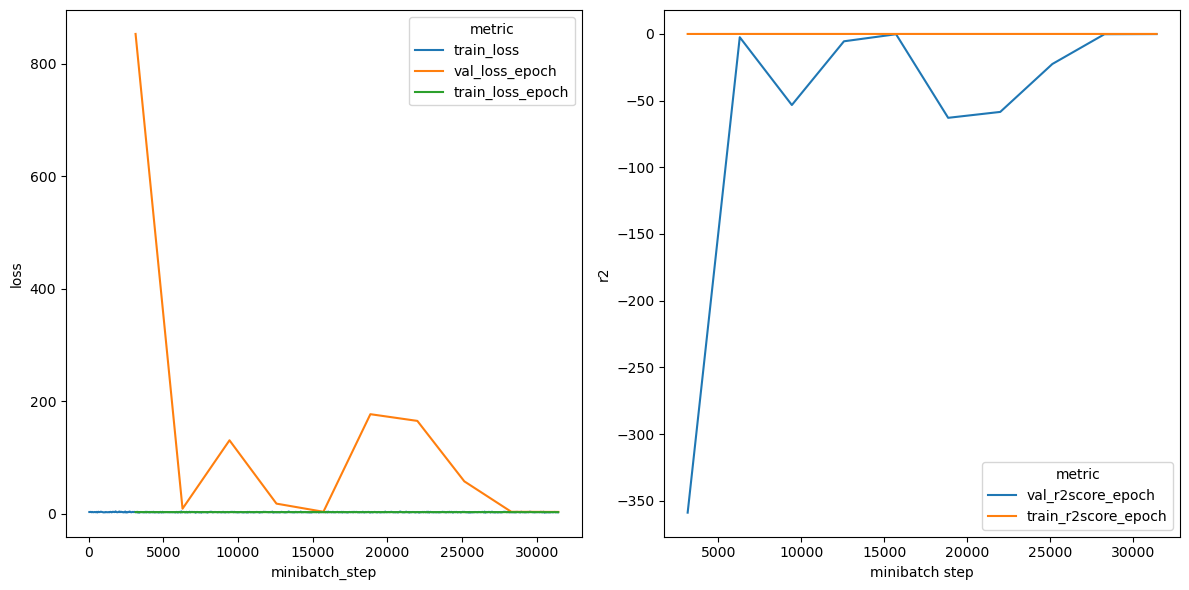

In [61]:
pl.training_summary(
    "/cellar/users/aklie/projects/ML4GLand/issues/41/tutorial_logs/DeepSTARR/Trial5"
)

In [ ]:
dd